<a href="https://colab.research.google.com/github/windaapriliyanti/Myskill/blob/main/transformers_for_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px
from plotly.offline import init_notebook_mode
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
import spacy

tqdm.pandas()
spacy_eng = spacy.load("en_core_web_sm")
nltk.download('stopwords')
lemm = WordNetLemmatizer()
init_notebook_mode(connected=True)
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 18

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Text Classification: Using Transformers Encoder Block
- A transformer is a deep learning model that adopts the mechanism of self-attention, differentially weighting the significance of each part of the input data
- They hold the potential to understand the relationship between sequential elements that are far from each other
- They are way more accurate
- They pay equal attention to all the elements in the sequence

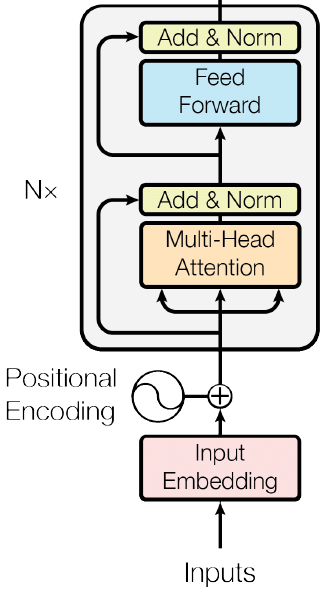

In [ ]:
data1 = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
data2 = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)

In [ ]:
data1 = data1[['headline','is_sarcastic']]
data2 = data2[['headline','is_sarcastic']]

data = pd.concat([data1,data2])
data.reset_index(drop=True, inplace=True)

In [ ]:
data

headline  is_sarcastic
0      thirtysomething scientists unveil doomsday clo...             1
1      dem rep. totally nails why congress is falling...             0
2      eat your veggies: 9 deliciously different recipes             0
3      inclement weather prevents liar from getting t...             1
4      mother comes pretty close to using word 'strea...             1
...                                                  ...           ...
55323               american politics in moral free-fall             0
55324                            america's best 20 hikes             0
55325                              reparations and obama             0
55326  israeli ban targeting boycott supporters raise...             0
55327                  gourmet gifts for the foodie 2014             0

[55328 rows x 2 columns]

# EDA and Text Preprocessing

## Checking for Missing Values

In [ ]:
data.isnull().sum()

headline        0
is_sarcastic    0
dtype: int64

## Finding the Classes Balance/Imbalance

In [ ]:
px.bar(data.groupby('is_sarcastic').count().reset_index(), x='headline',title='Count of Sarcastic and Genuine Headlines')

In [ ]:
data['is_sarcastic'].value_counts()

0    29970
1    25357
Name: is_sarcastic, dtype: int64

## Special Characters Removal
- We will not remove numbers from the text data right away, lets further analyse if they contain any relevant information
- We can find the entity type of the tokens in the sentences using Named Entity Recognition (NER), this will help us identify the type and relevance of numbers in our text data

In [ ]:
stop_words = stopwords.words('english')
stop_words.remove('not')

def text_cleaning(x):

    headline = re.sub('\s+\n+', ' ', x)
    headline = re.sub('[^a-zA-Z0-9]', ' ', x)
    headline = headline.lower()
    headline = headline.split()

    headline = [lemm.lemmatize(word, "v") for word in headline if not word in stop_words]
    headline = ' '.join(headline)

    return headline

In [ ]:
def get_entities(x):
    entity = []
    text = spacy_eng(x)
    for word in text.ents:
        entity.append(word.label_)
    return ",".join(entity)

data['entity'] = data['headline'].progress_apply(get_entities)

100%|██████████| 55328/55328 [08:39<00:00, 106.50it/s]


In [ ]:
nltk.download('wordnet')

data['clean_headline'] = data['headline'].apply(text_cleaning)

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
data['sentence_length'] = data['clean_headline'].apply(lambda x: len(x.split()))
data

headline  is_sarcastic  \
0      thirtysomething scientists unveil doomsday clo...             1   
1      dem rep. totally nails why congress is falling...             0   
2      eat your veggies: 9 deliciously different recipes             0   
3      inclement weather prevents liar from getting t...             1   
4      mother comes pretty close to using word 'strea...             1   
...                                                  ...           ...   
55323               american politics in moral free-fall             0   
55324                            america's best 20 hikes             0   
55325                              reparations and obama             0   
55326  israeli ban targeting boycott supporters raise...             0   
55327                  gourmet gifts for the foodie 2014             0   

             entity                                     clean_headline  \
0              DATE  thirtysomething scientists unveil doomsday clo...   
1           ORG,ORG  dem rep totally nail congress fall short gende...   
2          CARDINAL        eat veggies 9 deliciously different recipes   
3                              inclement weather prevent liar get work   
4                    mother come pretty close use word stream corre...   
...             ...                                                ...   
55323          NORP                  american politics moral free fall   
55324  GPE,CARDINAL                               america best 20 hike   
55325                                                reparations obama   
55326          NORP  israeli ban target boycott supporters raise al...   
55327          DATE                           gourmet gift foodie 2014   

       sentence_length  
0                    7  
1                   10  
2                    6  
3                    6  
4                    8  
...                ...  
55323                5  
55324                4  
55325                2  
55326                8  
55327                4  

[55328 rows x 5 columns]

## Headlines Length Distribution
- Look for outlier length of headline sentences
- Usually the headlines shouldn't be more than 20-30 words

In [ ]:
px.histogram(data, x="sentence_length",height=700, color='is_sarcastic', title="Headlines Length Distribution", marginal="box")

In [ ]:
data[data['sentence_length']==107]['headline']

7302    hot wheels ranked number one toy for rolling d...
Name: headline, dtype: object

In [ ]:
data.drop(data[data['sentence_length'] == 107].index, inplace = True)
data.reset_index(inplace=True, drop=True)

## Headlines Length Distribution: Outliers Removed
- The headlines after the removal of outliers do not exceed the limit of 20-30 words
- They are mostly centered in the range of 5-10 words

In [ ]:
px.histogram(data, x="sentence_length",height=700, color='is_sarcastic', title="Headlines Length Distribution", marginal="box")

## Filtering: Find Sentences that Contain Numbers

In [ ]:
data['contains_number'] = data['clean_headline'].apply(lambda x: bool(re.search(r'\d+', x)))
data

headline  is_sarcastic  \
0      thirtysomething scientists unveil doomsday clo...             1   
1      dem rep. totally nails why congress is falling...             0   
2      eat your veggies: 9 deliciously different recipes             0   
3      inclement weather prevents liar from getting t...             1   
4      mother comes pretty close to using word 'strea...             1   
...                                                  ...           ...   
55322               american politics in moral free-fall             0   
55323                            america's best 20 hikes             0   
55324                              reparations and obama             0   
55325  israeli ban targeting boycott supporters raise...             0   
55326                  gourmet gifts for the foodie 2014             0   

             entity                                     clean_headline  \
0              DATE  thirtysomething scientists unveil doomsday clo...   
1           ORG,ORG  dem rep totally nail congress fall short gende...   
2          CARDINAL        eat veggies 9 deliciously different recipes   
3                              inclement weather prevent liar get work   
4                    mother come pretty close use word stream corre...   
...             ...                                                ...   
55322          NORP                  american politics moral free fall   
55323  GPE,CARDINAL                               america best 20 hike   
55324                                                reparations obama   
55325          NORP  israeli ban target boycott supporters raise al...   
55326          DATE                           gourmet gift foodie 2014   

       sentence_length  contains_number  
0                    7            False  
1                   10            False  
2                    6             True  
3                    6            False  
4                    8            False  
...                ...              ...  
55322                5            False  
55323                4             True  
55324                2            False  
55325                8            False  
55326                4             True  

[55327 rows x 6 columns]

### Analysis of Samples Containing numbers of Time, Date or Cardinal Entity type
- The numbers in a text data can have different implications
- While the naive text preprocessing methods suggest that the numbers should be removed along with the special characters
- The entity type of these numbers should be identified to get their exact implications

### 10 Random Samples: Date Entity

In [ ]:
data[(data['contains_number']) & (data['sentence_length']<=5) & (data['entity']=='DATE')].sample(10)

headline  is_sarcastic entity  \
28899              6 summer salads you'll actually crave             0   DATE   
15007                 the 2016 'dumbing down' of america             0   DATE   
14537               here are all the 2018 grammy winners             0   DATE   
44768             oscars 2018: the complete winners list             0   DATE   
18755                     news roundup for july 12, 2017             0   DATE   
38462                             faith: 20 years strong             0   DATE   
49953                   news roundup for august 17, 2017             0   DATE   
30836  the 2018 winter olympics in pyeongchang, by th...             0   DATE   
8983                   the best and worst movies of 2015             0   DATE   
13795       slain cop had only 37 years until retirement             1   DATE   

                                clean_headline  sentence_length  \
28899           6 summer salads actually crave                5   
15007                     2016 dumbing america                3   
14537                      2018 grammy winners                3   
44768        oscars 2018 complete winners list                5   
18755                news roundup july 12 2017                5   
38462                    faith 20 years strong                4   
49953              news roundup august 17 2017                5   
30836  2018 winter olympics pyeongchang number                5   
8983                    best worst movies 2015                4   
13795             slay cop 37 years retirement                5   

       contains_number  
28899             True  
15007             True  
14537             True  
44768             True  
18755             True  
38462             True  
49953             True  
30836             True  
8983              True  
13795             True

### 10 Random Samples: Time Entity

In [ ]:
data[(data['contains_number']) & (data['sentence_length']<=5) & (data['entity']=='TIME')].sample(10)

headline  is_sarcastic entity  \
23122    'vacation is when i have a 40-hour week'             0   TIME   
29312        day chalked up as loss by 10:15 a.m.             1   TIME   
3409            man turns vegetarian for 36 hours             1   TIME   
12158               oven preheated for 16 seconds             1   TIME   
21538            jcpenney abandons 45-second sale             1   TIME   
26822            email from mom sent at 5:32 a.m.             1   TIME   
39547           man turns vegetarian for 36 hours             1   TIME   
43095            jcpenney abandons 45-second sale             1   TIME   
19067  the 1 minute blog. protesters and looting.             0   TIME   
55164            email from mom sent at 5:32 a.m.             1   TIME   

                        clean_headline  sentence_length  contains_number  
23122            vacation 40 hour week                4             True  
29312             day chalk loss 10 15                5             True  
3409      man turn vegetarian 36 hours                5             True  
12158           oven preheat 16 second                4             True  
21538  jcpenney abandon 45 second sale                5             True  
26822              email mom send 5 32                5             True  
39547     man turn vegetarian 36 hours                5             True  
43095  jcpenney abandon 45 second sale                5             True  
19067    1 minute blog protesters loot                5             True  
55164              email mom send 5 32                5             True

### 10 Random Samples: Cardinal Entity

In [ ]:
data[(data['contains_number']) & (data['sentence_length']<=5) & (data['entity']=='CARDINAL')].sample(10)

headline  is_sarcastic  \
18992             6 things to look for in your next home             0   
51927          11 camping essentials you'll actually use             0   
25261           senator's myspace top 8 all corporations             1   
9504                 10 winning recipes for the big game             0   
8917                         6 tips to boost your career             0   
48112          10 things not to do before your next race             0   
50946  is your relationship unhealthy? 2 questions to...             0   
33436              5 ways to make cocoa more sustainable             0   
47562          10 ways to deal with a difficult coworker             0   
36537                  5 ways to trick your inner critic             0   

         entity                         clean_headline  sentence_length  \
18992  CARDINAL                6 things look next home                5   
51927  CARDINAL        11 camp essentials actually use                5   
25261  CARDINAL     senator myspace top 8 corporations                5   
9504   CARDINAL                10 win recipes big game                5   
8917   CARDINAL                     6 tip boost career                4   
48112  CARDINAL                10 things not next race                5   
50946  CARDINAL  relationship unhealthy 2 question ask                5   
33436  CARDINAL          5 ways make cocoa sustainable                5   
47562  CARDINAL        10 ways deal difficult coworker                5   
36537  CARDINAL              5 ways trick inner critic                5   

       contains_number  
18992             True  
51927             True  
25261             True  
9504              True  
8917              True  
48112             True  
50946             True  
33436             True  
47562             True  
36537             True

**Inference:** A lot of these headlines wouldn't make sense without these time,date or even cardinal numbers. For now we can let them be a part of our clean text data.

# Word Visualization: Word Clouds

In [ ]:
sarcastic = data[data['is_sarcastic']==1]['clean_headline'].tolist()
genuine = data[data['is_sarcastic']==0]['clean_headline'].tolist()

## Top 50 Words: Sarcastic Headlines

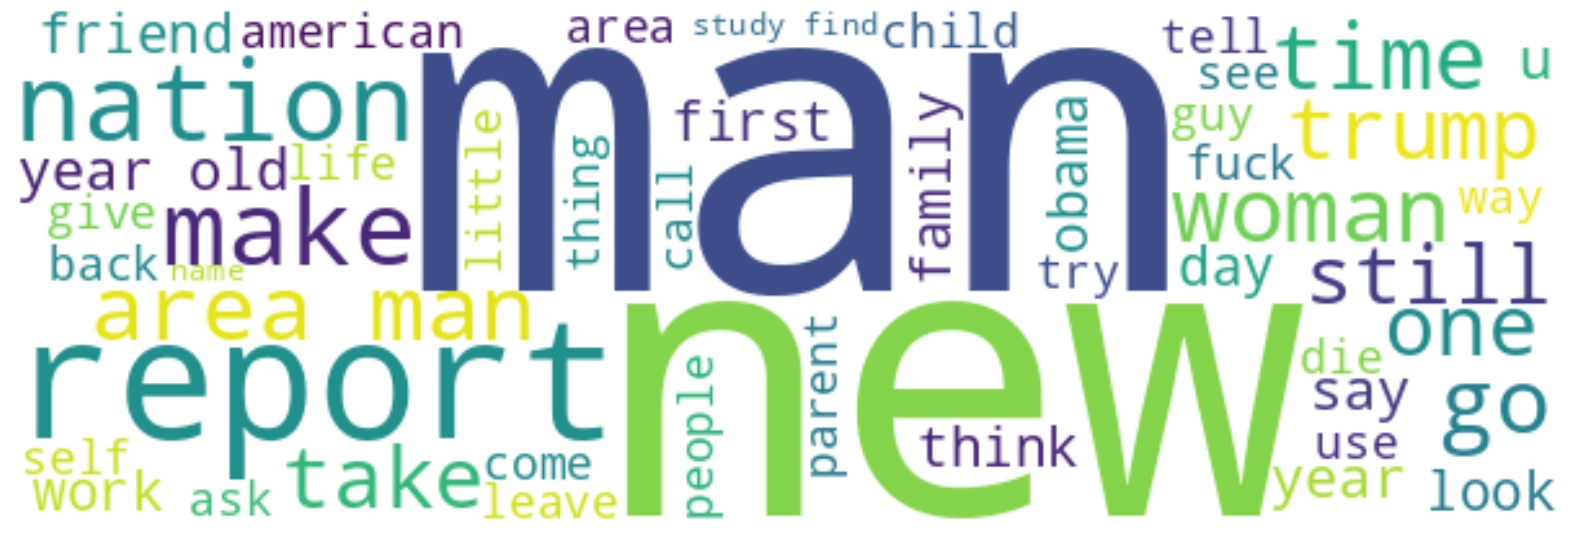

In [ ]:
wordcloud = WordCloud(max_words=50, width=600, background_color='white').generate(" ".join(sarcastic))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Top 50 Words: Genuine Headlines

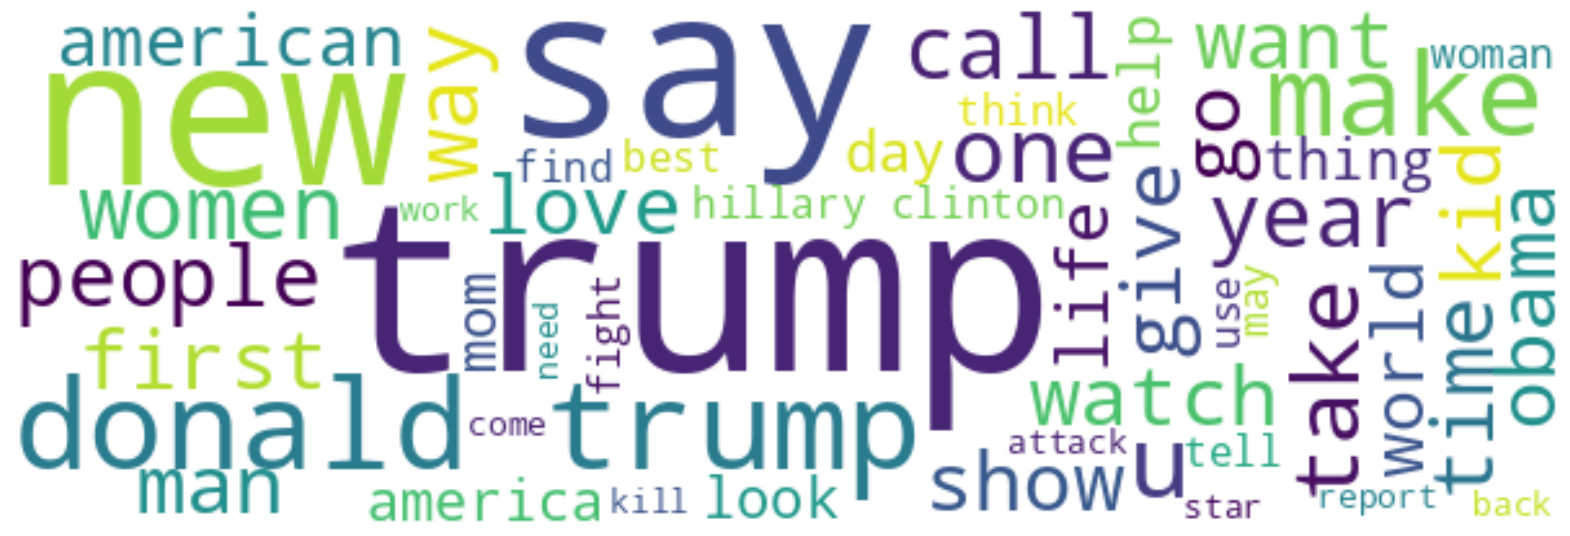

In [ ]:
wordcloud = WordCloud(max_words=50, width=600, background_color='white').generate(" ".join(genuine))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Model Building

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [ ]:
sentences = data['clean_headline']
label = data['is_sarcastic']

## Train - Validation - Test Splitting (80:10:10)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(sentences, label, test_size=0.2, stratify=label, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=42)

## Tokenization
- Splitting sentences into words
- Finding the vocab size

In [ ]:
max_len = 20
oov_token = '00_V'
padding_type = 'post'
trunc_type = 'post'

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)

Vocab Size:  20886


## Encoding of Inputs
- Converting the sentences to token followed by padded sequences in encoded format
- These are numeric encodings assigned to each word

In [ ]:
train_sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(val_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

## Transformers: Attention is all you need
- For the purpose of classification problem we will only use the encoder block of the original transformers model (encoder-decoder) designed for sequence problems
- Image below is from Jay Alamar's Blog ( For detailed explanation: https://jalammar.github.io/illustrated-transformer/ )

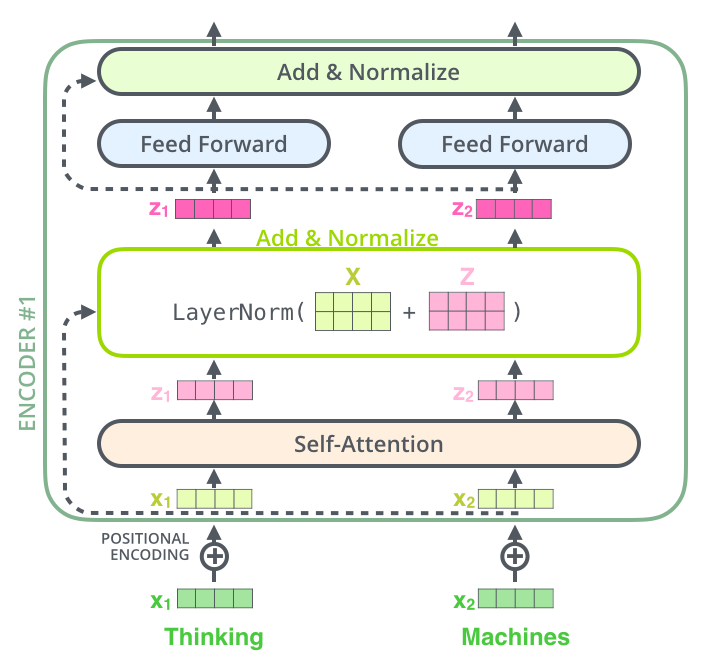

## Multi-Headed Attention
- Multi-head Attention is a module for attention mechanisms which runs through an attention mechanism several times in parallel. The independent attention outputs are then concatenated and linearly transformed into the expected dimension.
- The Self Attention mechanism (illustrated in picture above next to the picture of encoder block) is used several times in parallel in Multi-Head attention
- Multiple attention heads allows for attending to parts of the sequence differently
- During self attention a word's attention score with itself will be the highest, therefore by using mutli-head attention a word can establish its relationship with other words in the sequence by calculating the attention scores with them in parallel

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Model Definition

In [ ]:
embed_dim = 50
heads = 2
neurons = 32
maxlen = 20
vocab_size = 20886

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = Dropout(0.35)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 token_and_position_embeddi  (None, 20, 50)            1045300   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_encoder (Trans  (None, 20, 50)            23832     
 formerEncoder)                                                  
                                                                 
 global_average_pooling1d (  (None, 50)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 50)                0     

## Model Training

In [ ]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0.001, patience = 1, verbose = 1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [ ]:
history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs=25,
                    batch_size=32,
                    callbacks=[earlystopping])

Epoch 1/25
1384/1384 [==============================] - 53s 36ms/step - loss: 0.4655 - accuracy: 0.7667 - val_loss: 0.3352 - val_accuracy: 0.8570
Epoch 2/25
1384/1384 [==============================] - 50s 36ms/step - loss: 0.2462 - accuracy: 0.9025 - val_loss: 0.3062 - val_accuracy: 0.8818
Epoch 3/25
1384/1384 [==============================] - 45s 32ms/step - loss: 0.1720 - accuracy: 0.9372 - val_loss: 0.2849 - val_accuracy: 0.9085
Epoch 4/25
1384/1384 [==============================] - 43s 31ms/step - loss: 0.1272 - accuracy: 0.9545 - val_loss: 0.2784 - val_accuracy: 0.9152
Epoch 5/25
1384/1384 [==============================] - 45s 33ms/step - loss: 0.0857 - accuracy: 0.9712 - val_loss: 0.2787 - val_accuracy: 0.9360
Epoch 5: early stopping


# Model Evaluation

## Learning Curves
- Loss Curve
- Accuracy Curve

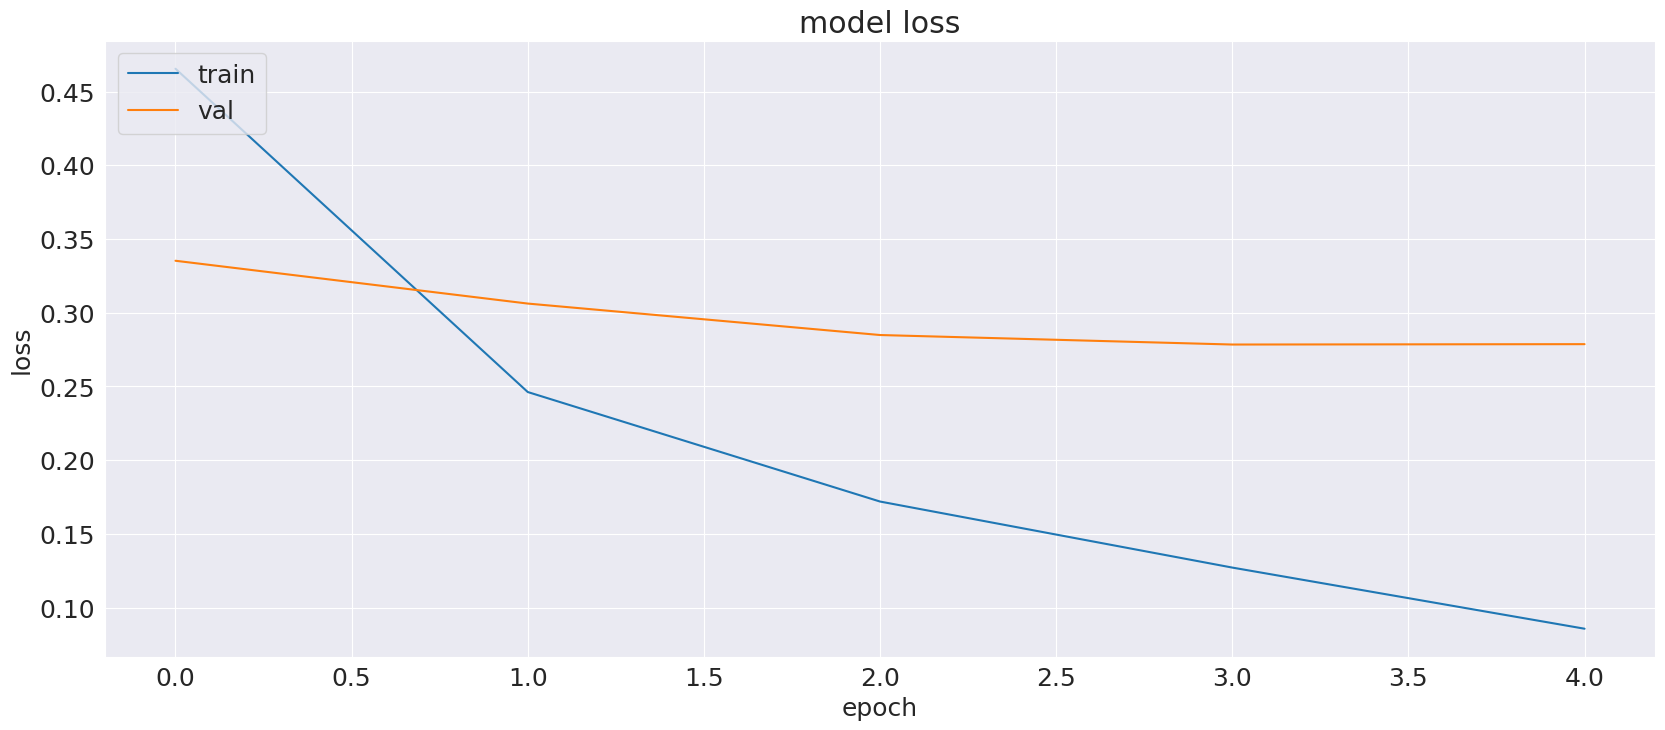

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

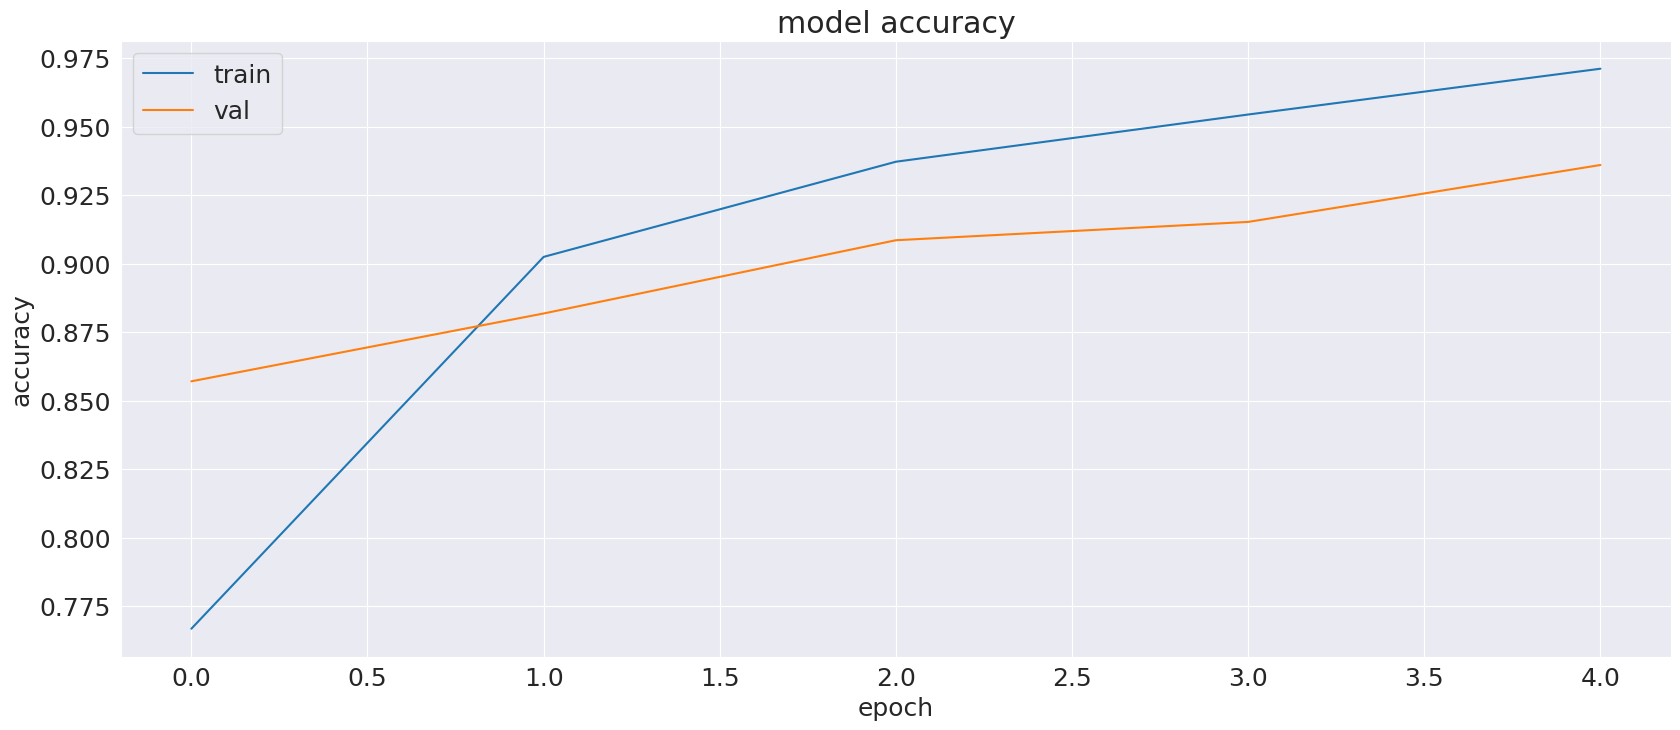

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Inference:** In case of overfitting use the traditional methods
- Low learning rate
- L1-L2 Regularization
- Dropout
- Lesser Neurons in MLP layers
- Early Stopping
- etc.

## Classification Metrics
- Since it is important to not misclassify the genuine headlines as sarcastic headlines we will also look at the roc auc score to avoid misclassification of genuine headlines as sarcastic headlines

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

### ROC Curve

173/173 [==============================] - 1s 6ms/step


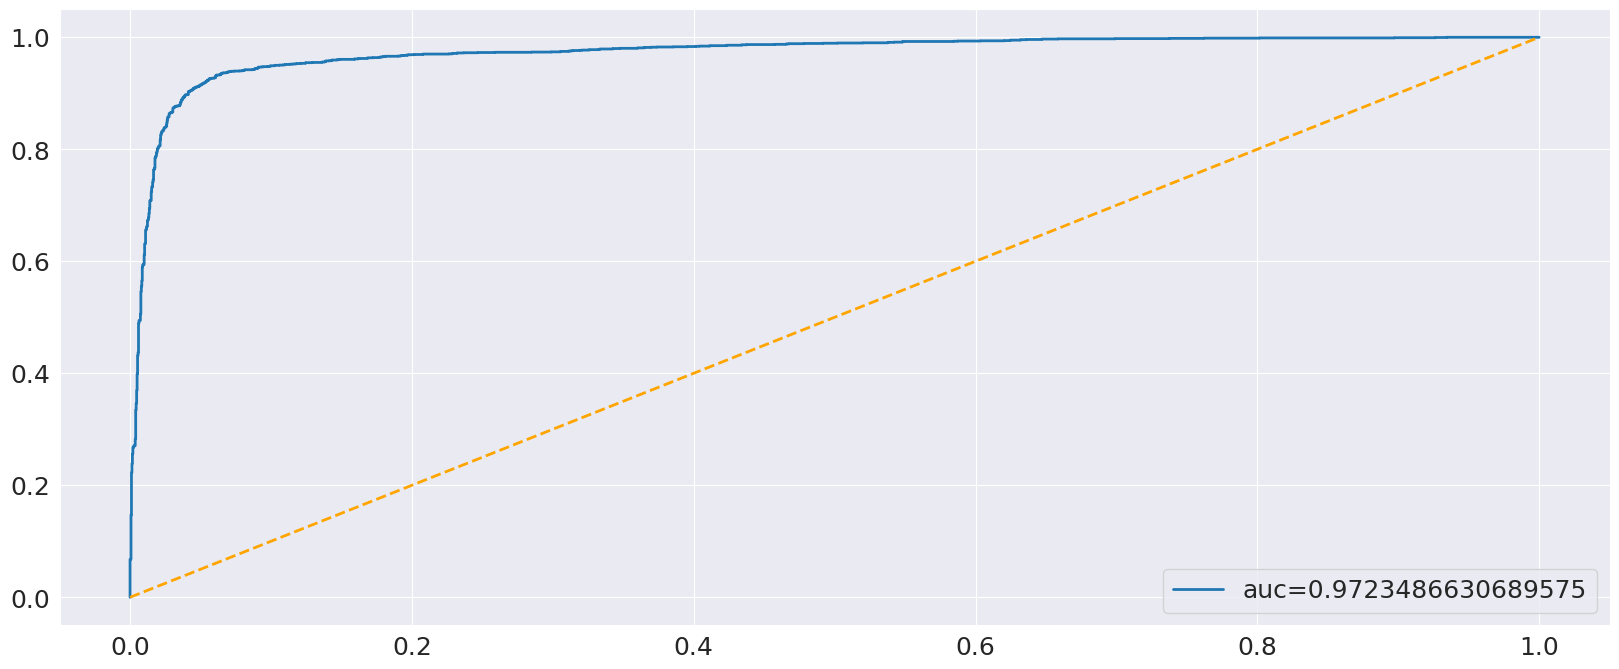

In [ ]:
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="auc="+str(auc),lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.legend(loc=4)
plt.show()

### Scores: Test Set Result

In [ ]:
y_pred[y_pred>=0.85] = 1
y_pred[y_pred<0.85] = 0

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2997
           1       0.95      0.90      0.92      2536

    accuracy                           0.93      5533
   macro avg       0.93      0.93      0.93      5533
weighted avg       0.93      0.93      0.93      5533



### Confusion Matrix

<Axes: >

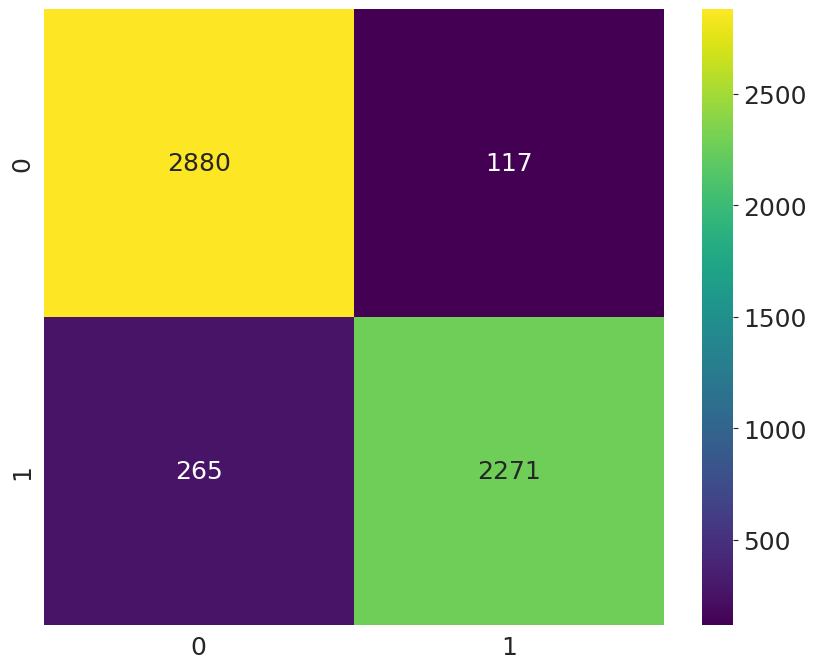

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.4g',cmap='viridis')